# importing stuff 

In [1]:
import numpy as np
from pathlib import Path as P
import pickle
# from visualize_utils import make_vid
# import cv2

    
    
result_path = P('/mnt/12T/DJ/PCDet_output/IA-SSD-GAN-vod-aug/debug/eval/checkpoint_epoch_11')
data_ids = np.loadtxt(str(result_path / 'frame_ids.txt'), delimiter=',', dtype=str)[:-1]

with open(str(result_path / 'gt.pkl'), 'rb') as f:
    gt = pickle.load(f)

# load det
with open(str(result_path / 'dt.pkl'), 'rb') as f:
    dt = pickle.load(f)
from vod.visualization.settings import label_color_palette_2d
from matplotlib.lines import Line2D

keys = list(gt.keys())
cls_name = ['Car','Pedestrian', 'Cyclist', 'Others']
color_dict = {}
for i, v in enumerate(cls_name):
    color_dict[v] = label_color_palette_2d[v]
import open3d as o3d
from scipy.spatial.transform import Rotation as R
def get_radar(fname):
    assert fname.exists()
    radar_point_cloud = np.fromfile(str(fname), dtype=np.float32).reshape(-1, 7)
    return radar_point_cloud

def get_lidar(fname):
    assert fname.exists()
    radar_point_cloud = np.fromfile(str(fname), dtype=np.float32).reshape(-1, 4)
    return radar_point_cloud

def pcd_formating(pcd):
    num_pts = pcd.shape[0]
    zeros_pad = np.zeros([num_pts, 1])
    final_pcd = np.concatenate((zeros_pad, pcd), axis=1)
    return final_pcd

def get_rotation(yaw):
    # x,y,_ = arr[:3]
    # yaw = np.arctan(y/x)
    angle = np.array([0, 0, yaw])
    r = R.from_euler('XYZ', angle)
    return r.as_matrix()

def get_bbx_param(obj_info):

    center = obj_info[:3]
    extent = obj_info[3:6] + np.array([0, 0, 10])
    angle = -obj_info[6]
    # center[-1] += 0.5 * extent[-1]

    rot_m = get_rotation(angle)

    obbx = o3d.geometry.OrientedBoundingBox(center.T, rot_m, extent.T)
    return obbx

def get_pred_dict(dt_file):
    '''
    reads results.pkl file
    returns dictionary with str(frame_id) as key, and list of strings, 
    where each string is a predicted box in kitti format.
    '''
    dt_annos = []

    # load detection dict
    with open(dt_file, 'rb') as f:
        infos = pickle.load(f)
        dt_annos.extend(infos)      
    labels_dict = {}
    for j in range(len(dt_annos)):
        labels = []
        curr = dt_annos[j]
        frame_id = curr['frame_id']
        
        # no predicted 
        if len(dt_annos[j]['name']) == 0: 
            labels += []
        
        else:
            for i in range(len(dt_annos[j]['name'])):       
                # extract the relevant info and format it 
                line = [str(curr[x][i]) if not isinstance(curr[x][i],np.ndarray) else [y for y in curr[x][i]]  for x in list(curr.keys())[:-2]]
                flat = [str(num) for item in line for num in (item if isinstance(item, list) else (item,))]
                
                # L,H,W -> H,W,L 
                flat[9],flat[10] = flat[10],flat[9]
                flat[8],flat[10] = flat[10],flat[8]
                
                labels += [" ".join(flat)]

        labels_dict[frame_id] = labels
    return labels_dict


Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.


# get rcs/vcomp data

In [2]:
from visualize_point_based import transform_anno, drawBEV
from tqdm import tqdm
anno_type = 'gt'

idx = 5 # 3: rcs, 5: vcomp
is_radar = True

pred_dict = get_pred_dict(result_path / 'result.pkl')
frame_ids = list(pred_dict.keys())

class_dict = {

    }
for frame in tqdm(frame_ids):
    if anno_type == 'pred':
        anno = dt[frame][0]
    else:
        anno = gt[frame]
    loc = anno['location']
    yaw = anno['rotation_y']
    extent = anno['dimensions']

    if is_radar:
        data_path = P('/mnt/12T/public/view_of_delft/radar/training/velodyne')
        pc = get_radar(data_path / (frame + '.bin'))
        original_pc = pc 
    else:
        data_path = P('/mnt/12T/public/view_of_delft/lidar/training/velodyne')
        pc = get_lidar(data_path / (frame + '.bin'))
        original_pc = pc 
    pc = pcd_formating(pc)

    pcd = o3d.geometry.PointCloud()
    pcd.points = o3d.utility.Vector3dVector(pc[:,1:4])



    for cur_label_idx in range(len(anno['name'])):
        x, y, z = transform_anno(loc[cur_label_idx], frame, is_radar=is_radar)
        dx, dy, dz = extent[cur_label_idx]
        rot_y = yaw[cur_label_idx]
        obj_info = np.array([x, y, z, dx, dy, dz, rot_y])
        box = get_bbx_param(obj_info)
        ctr_idx = box.get_point_indices_within_bounding_box(pcd.points)
        # print(str(len(ctr_idx)) + ' ' +str(anno['name'][cur_label_idx]))

        # print(anno['name'][cur_label_idx] )
        if anno['name'][cur_label_idx] not in class_dict:
            class_dict[anno['name'][cur_label_idx]] = list(original_pc[ctr_idx][:,idx])
        else:
            class_dict[anno['name'][cur_label_idx]] += list(original_pc[ctr_idx][:,idx])

100%|██████████| 1296/1296 [00:06<00:00, 191.20it/s]


In [3]:
# with open('v_comp.pkl', 'wb') as f:
#     pickle.dump(class_dict, f)
        


In [56]:

import matplotlib.pyplot as plt
import pandas as pd


load_rcs = True 
stat = 'rcs' if load_rcs else 'vcomp'
if load_rcs:
    with open('rcs.pkl', 'rb') as f:
        loaded_dict = pickle.load(f)

else:
    with open('v_comp.pkl', 'rb') as f:
        loaded_dict = pickle.load(f)


pd_dict = {
}
for c in loaded_dict.keys():
    if c != 'DontCare':
        pd_dict[c] = [
            np.mean(loaded_dict[c]),
            np.std(loaded_dict[c]),
            np.var(loaded_dict[c]),
            np.min(loaded_dict[c]),
            np.max(loaded_dict[c]),
            np.median(loaded_dict[c])]

df = pd.DataFrame.from_dict(pd_dict,orient='index',columns=['mean','std','var','min','max','median'])

print(stat)
display(df)






rcs


,mean,std,var,min,max,median
bicycle,-12.250071,7.422388,55.091846,-44.012520,32.750786,-12.441455
Car,-18.408291,10.173301,103.496048,-51.974403,28.303001,-19.614038
motor,-18.770540,12.136926,147.304962,-53.839314,-0.584503,-15.057426
Pedestrian,-15.729727,7.119473,50.686886,-54.661842,19.650768,-15.065382
ride_other,-15.830435,6.410652,41.096455,-32.776226,6.814144,-15.580935
truck,-16.678188,9.101404,82.835564,-39.752480,20.434872,-16.438835
Cyclist,-15.349323,7.251072,52.578053,-60.372944,13.388092,-15.146022
rider,-15.073532,6.982631,48.757137,-43.040546,13.388092,-15.009413
moped_scooter,-12.555849,7.272213,52.885078,-52.861938,4.769234,-12.189442
bicycle_rack,-11.020327,6.574647,43.225983,-40.839878,17.042030,-10.726303


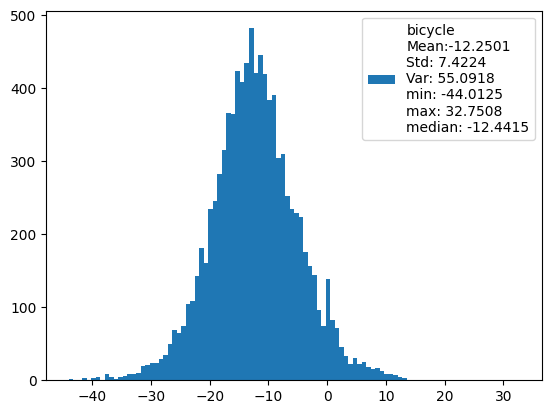

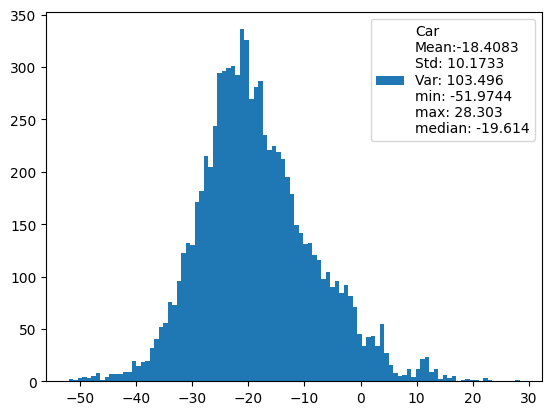

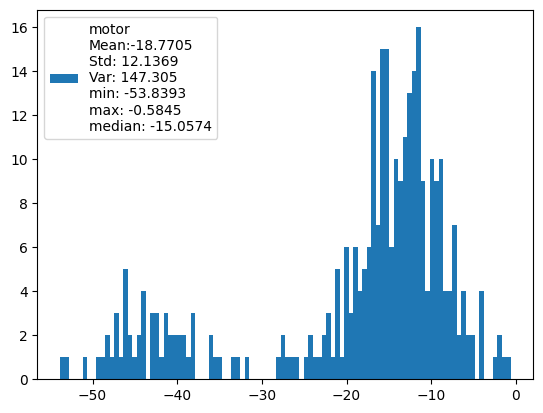

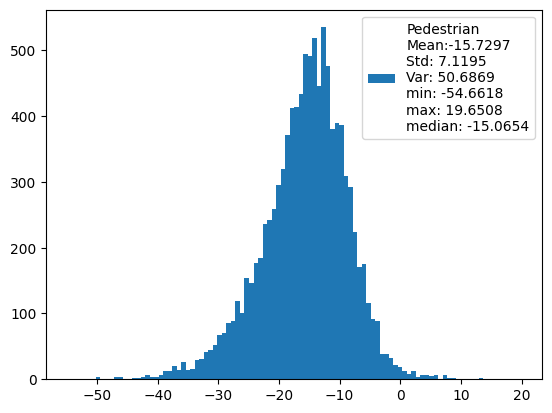

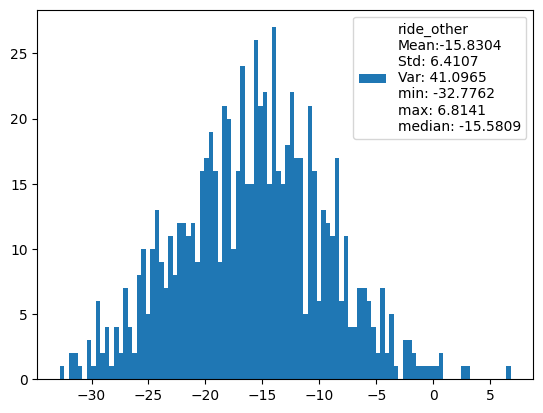

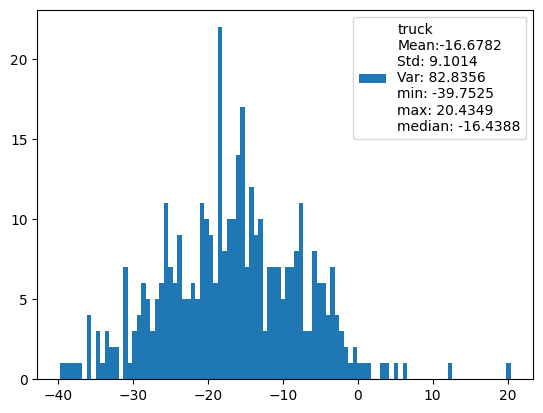

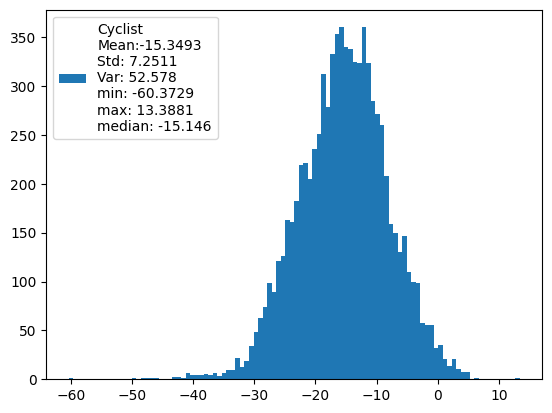

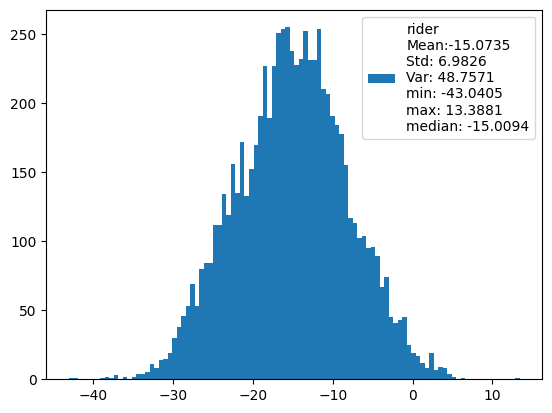

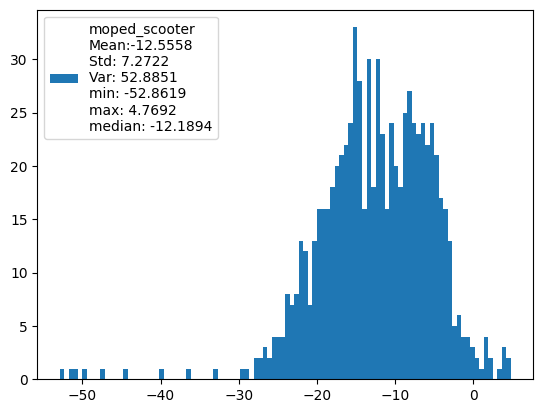

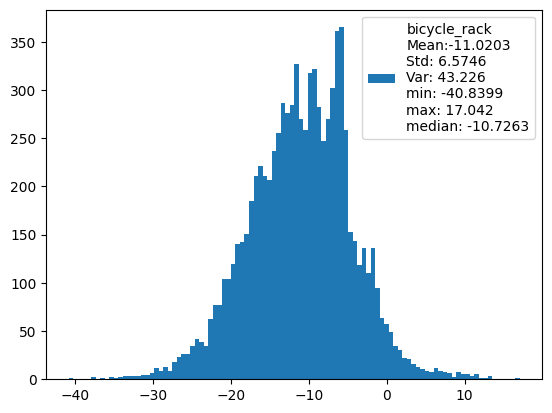

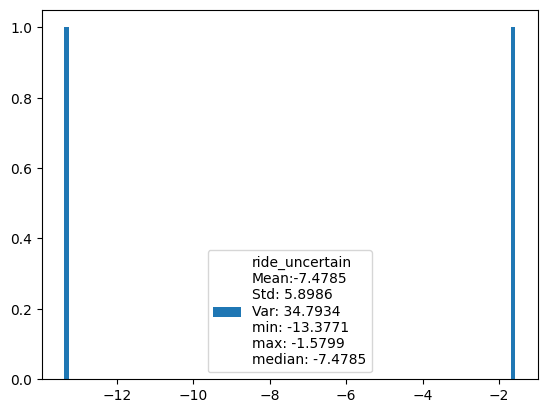

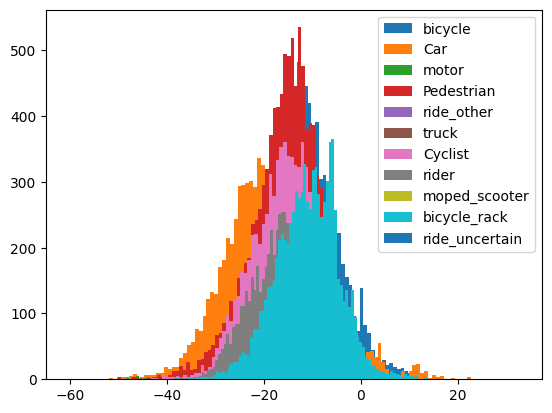

In [57]:
path = f'/root/gabriel/code/parent/CenterPoint-KITTI/output/vod_vis/{stat}_plots/'
for c in loaded_dict.keys():
    if c != 'DontCare':
        # label_str = c+f'\nMean:{str(np.round(pd_dict[c][0],4))}\n \
        #                 Std: {str(np.round(pd_dict[c][1],4))}\n \
        #                 Var: {str(np.round(pd_dict[c][2],4))}\n \
        #                 min: {str(np.round(pd_dict[c][3],4))}\n \
        #                 max: {str(np.round(pd_dict[c][4],4))}\n \
        #                 median: {str(np.round(pd_dict[c][5],4))}'
        plt.hist(loaded_dict[c],100,label=c+f'\nMean:{str(np.round(pd_dict[c][0],4))}\nStd: {str(np.round(pd_dict[c][1],4))}\nVar: {str(np.round(pd_dict[c][2],4))}\nmin: {str(np.round(pd_dict[c][3],4))}\nmax: {str(np.round(pd_dict[c][4],4))}\nmedian: {str(np.round(pd_dict[c][5],4))}')
        plt.legend()
        plt.savefig(path+c+'.png')
        plt.show()


for c in loaded_dict.keys():
    if c != 'DontCare':
    
        plt.hist(loaded_dict[c],100,label=c)
        plt.legend()
plt.savefig(path+'all'+'.png')
plt.show()